# XAI - Homework 1 - Barbara Bugała


## Task A

Calculate Shapley values for player A given the following value function

$v(\emptyset) = 0 \\
v(A) = 20 \\
v(B) = 20 \\
v(C) = 60 \\
v(A,B) = 60 \\
v(A,C) = 70 \\
v(B,C) = 70 \\
v(A,B,C) = 100 $

contributions of player A:

$v(A) - v(\emptyset) = 20$ \
$v(A,B) - v(B) = 40$ \
$v(A,C) - v(C) = 10$ \
$v(A,B,C) - v(B,C) = 30$

number of players $ \rightarrow |P| = 3$

shap values for player A:

$\phi_A = \frac{2}{6} *20 + \frac{1}{6}* 40 + \frac{1}{6} *10 + \frac{2}{6}* 30 = 25$

## Task B

In [ ]:
# imports
import xgboost as xgb
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import shap
import itertools
import numpy as np

In [4]:
# read data
data = pd.read_csv("phoneme.csv")
X = data.drop(["Unnamed: 0", "TARGET"], axis = 1).values
y = data["TARGET"].values

# split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# datasets and dataloaders
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train,dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))
training_data = DataLoader(train_dataset, batch_size= 64, shuffle=True)
testing_data = DataLoader(test_dataset, batch_size=64, shuffle=True)

I’ll be using the Phoneme dataset, which has 5 numerical features and a binary target variable (1 or 2) representing two phoneme classes.

In [9]:
display(data.drop(["Unnamed: 0"], axis = 1).head())

,V1,V2,V3,V4,V5,TARGET
0,0.489927,-0.451528,-1.047990,-0.598693,-0.020418,1
1,-0.641265,0.109245,0.292130,-0.916804,0.240223,1
2,0.870593,-0.459862,0.578159,0.806634,0.835248,1
3,-0.628439,-0.316284,1.934295,-1.427099,-0.136583,1
4,-0.596399,0.015938,2.043206,-1.688448,-0.948127,1


### Model Training (XGBoost)

We train an **XGBoost** model to classify the two phoneme classes.  

In [10]:
model_xgb = xgb.XGBRegressor(objective = "reg:squarederror")
model_xgb.fit(X_train, y_train)

y_pred = model_xgb.predict(X_test)

In [11]:
# generate random numbers that will be used for shap analysis
random1 = random.randint(0, len(test_dataset) - 1)
random2 = random.randint(0, len(test_dataset) - 1)

In [14]:
# calculation of f(\empty), taking a mean of all data samples
baseline = X_test.mean(axis = 0).reshape(1, 5)
f_baseline = model_xgb.predict(baseline)[0]
print("The value of f(empty) is: ", f_baseline)

The value of f(empty) is:  1.1356814


We approximate SHAP values using Monte Carlo sampling:

1. Start from a **baseline input**.
2. Randomly permute the feature order.
3. For each permutation:
   - Add features one by one.
   - Record how much the model output changes.
4. Average these changes across all permutations.

In [7]:
psi = np.zeros(5)

for perm in itertools.permutations([0, 1, 2, 3, 4]):
    x = baseline.copy()
    prev_pred = model_xgb.predict(x)[0]
    for i in perm:
        x[0][i] = X_test[random1][i]
        pred = model_xgb.predict(x)[0]
        psi[i] += pred - prev_pred
        prev_pred = pred


psi /= 120
print("Shap for attibutions: ", psi)
print("predicted models output: ", psi.sum() + f_baseline)
print("actual model output: ", model_xgb.predict(X_test[random1].reshape(1, -1))[0])

Shap for attibutions:  [-0.46673081 -0.01072917  0.26250805  0.05356276 -0.03820485]
predicted models output:  0.9360873699188232
actual model output:  0.93608737


Shap values from shap library

In [8]:
explainer = shap.Explainer(model_xgb, baseline)
shap_values = explainer(X_test)

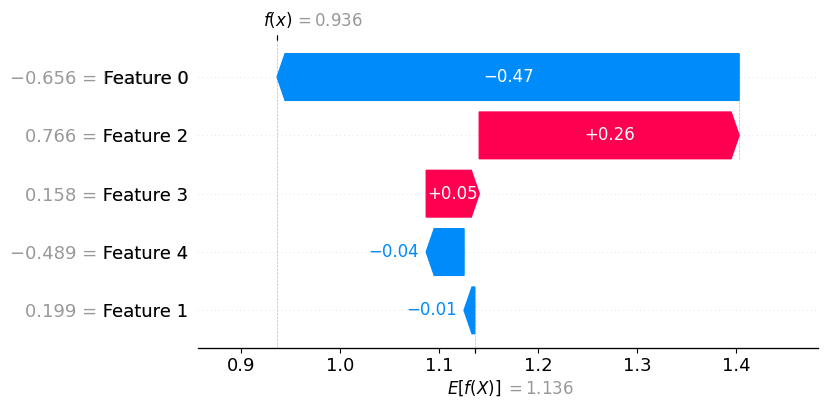

In [9]:
shap.plots.waterfall(shap_values[random1])

*The results are not identical, but they are quite similar. The overall impact on the final prediction of each feature seems to be preserved.*


Second example, calculation from self-made shap 

In [10]:
psi = np.zeros(5)

for perm in itertools.permutations([0, 1, 2, 3, 4]):
    x = baseline.copy()
    prev_pred = model_xgb.predict(x)[0]
    for i in perm:
        x[0][i] = X_test[random2][i]
        pred = model_xgb.predict(x)[0]
        psi[i] += pred - prev_pred
        prev_pred = pred


psi /= 120
print("Shap for attibutions: ", psi)
print("predicted models output: ", psi.sum() + f_baseline)
print("actual model output: ", model_xgb.predict(X_test[random2].reshape(1, -1))[0])

Shap for attibutions:  [0.30533292 0.24454349 0.03187849 0.0176059  0.02070512]
predicted models output:  1.7557473182678223
actual model output:  1.7557473


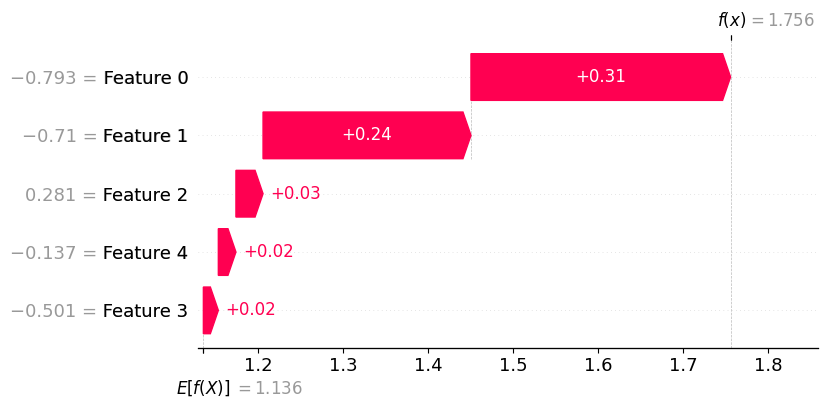

In [11]:
shap.plots.waterfall(shap_values[random2])

*In this example results also look very similar to the ones in the self-made shap calculation. There are small differences but it looks very good.*

### Neural net

In [ ]:
class Net(nn.Module):
    def __init__(self, in_params, out_params, hidden):
        super().__init__()
        self.fc1 = nn.Linear(in_params, hidden)
        self.fc2 = nn.Linear(hidden, out_params)
        self.tanh = nn.Tanh()
        self.bn1 = nn.BatchNorm1d(hidden)

    def forward(self, x):
        x = self.fc1(x)
        x = self.tanh(x)
        x = self.bn1(x)
        x = self.fc2(x)
        x = self.tanh(x)

        return x

In [ ]:
model = Net(6, 1, 10)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
criterion = torch.nn.MSELoss()

epochs = 5
losses = []

In [ ]:
model.train()
for epoch in range(epochs):
    for x, y in training_data:
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(y, output.squeeze(-1))
        loss.backward()
        optimizer.step()
        losses.append(loss.detach().cpu().item())

In [ ]:
plt.plot(losses)
plt.show()

In [ ]:
model.eval()
correct = 0
all = 0
with torch.no_grad():
    for x, y in testing_data:
        optimizer.zero_grad()
        output = torch.sign(model(x)).view(-1)
        correct += (output == y).sum().item()
        all += y.size(0)

    print(correct / all  * 100)


The accuraccy looks very good, but mostly because the dataset is very imbalanced with imbalance ratio over 40.

In [ ]:
random1 = random.randint(0, len(test_dataset) - 1)
random2 = random.randint(0, len(test_dataset) - 1)

random_sample1_torch = test_dataset[random1][0]
random_sample2_torch = test_dataset[random2][0]

random_sample1_numpy = X_test[random1]
random_sample2_numpy = X_test[random2]

In [ ]:
output_sample1 = model(random_sample1_torch.unsqueeze(0))
output_sample2 = model(random_sample2_torch.unsqueeze(0))

In [ ]:
print(random_sample1_torch)

In [ ]:
# model.eval()

# explainer = shap.GradientExplainer(model, test_dataset[:100][0])
# shap_values = explainer(test_dataset[:100][0])
# shap.plots.waterfall(shap_values[0])

## Task C

In this task, I will perform an analysis on the more imbalanced Mammography dataset. The target variable takes values in {-1, 1}, and the class imbalance is considerably higher compared to Task B.

In [12]:
# read data
data_more_imbalanced = pd.read_csv("mammography.csv")
X_mI = data_more_imbalanced.drop(["Unnamed: 0", "TARGET"], axis = 1).values
y_mI = data_more_imbalanced["TARGET"].values

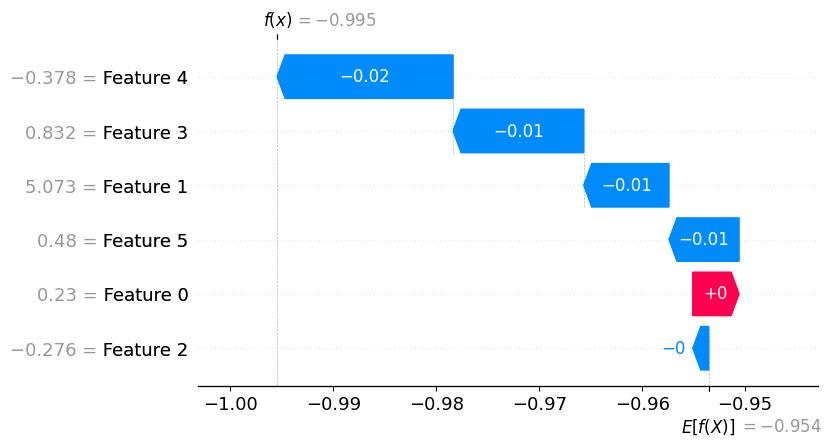

In [13]:
model_xgb = xgb.XGBRegressor(objective = "reg:squarederror")
model_xgb.fit(X_mI, y_mI)

explainer = shap.Explainer(model_xgb)
shap_values = explainer(X_mI)
shap.plots.waterfall(shap_values[0])

*The difference is evident: the SHAP values are substantially smaller, with the maximum absolute value usually below 0.03, whereas in the previous analysis they reached values as high as 0.5.*